<a href="https://colab.research.google.com/github/Hutaf/Speech-Emotion-Recognition/blob/main/Baseline(MLP_SVM_DT_XGB).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Speech Emotion Recognition**
## Baseline models



# Install following libraries

In [1]:
!pip install librosa  
!pip install soundfile
!pip install pyaudio

  ERROR: Failed building wheel for pyaudio
  Running setup.py clean for pyaudio
Failed to build pyaudio
    Running setup.py install for pyaudio ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-37a57e_3/pyaudio/setup.py'"'"'; __file__='"'"'/tmp/pip-install-37a57e_3/pyaudio/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-9u1kixj1/install-record.txt --single-version-externally-managed --compile Check the logs for full command output.


# Import libraries 

In [30]:
import librosa
import librosa.display
import soundfile
import os, glob, pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC 
from sklearn.tree import DecisionTreeClassifier 
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Exploratory Data Analysis

In [4]:
def extract_feature(file_name, mfcc, chroma, mel, tonnetz, contrast):
        X, sample_rate = librosa.load(os.path.join(file_name), res_type='kaiser_fast')
        result = np.array([])
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
            result = np.array([])
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
        return result

Now, let’s define a dictionary to hold numbers and the emotions available in the RAVDESS, and a list to hold all emotions:
 1. Neutral
 2. Calm
 3. Happy
 4. Sad
 5. Angry
 6. Fearful
 7. Disgust
 8. Surprised 

In [5]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}
# Emotions to observe
observed_emotions = ['neutral','calm','angry', 'happy','disgust','sad','fearful','surprised']

## Load the data and extract features for each sound file

In [6]:
def load_data(test_size=0.2):
    X,y=[],[]
    for file in glob.glob('/content/drive/MyDrive/Data/Actor_*/*.wav'):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
       
        # we allow only AVAILABLE_EMOTIONS we set
        if emotion not in observed_emotions:
            continue
       
         # extract speech features
        feature=extract_feature(file, 
                                mfcc=True, 
                                chroma=True, 
                                mel=True, 
                                tonnetz=False, 
                                contrast=False)
    
        X.append(feature)
        y.append(emotion)

    return train_test_split(np.array(X), 
                            y, 
                            test_size = test_size,
                            random_state=42)

# Load the data

In [4]:
filepath = 'https://raw.githubusercontent.com/Hutaf/Speech-Emotion-Recognition/main/Data/MFCC_Data.csv'
data = pd.read_csv(filepath)

In [5]:
print(data.head())

   Unnamed: 0           0          1  ...        38        39      0.1
0           0 -536.606430  64.556708  ...  2.319079  0.520878     calm
1           1 -544.708321  56.414519  ... -0.042497  0.889718  neutral
2           2 -574.430922  56.297725  ...  1.244445  3.589855  neutral
3           3 -553.569230  62.088209  ...  1.572597  2.003235  neutral
4           4 -602.211476  56.717853  ...  4.953895  5.449686  neutral

[5 rows x 42 columns]


In [6]:
data.columns

Index(['Unnamed: 0', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '0.1'],
      dtype='object')

In [7]:
data = data.drop('Unnamed: 0',axis=1)
data = data.rename(columns = {'0.1': 'emotion'})

In [8]:
data.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', 'emotion'],
      dtype='object')

## Split the Dataset
Time to split the dataset into training and testing sets! 

In [9]:
# Features and target columns
X = data.drop('emotion', axis = 1).values
y = data['emotion'].values

In [11]:
# Split the dataset
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.20)

###Observe the shape of the training and testing datasets:

In [12]:
# print some details
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in testing data
print("[+] Number of testing samples:", X_test.shape[0])

[+] Number of training samples: 1152
[+] Number of testing samples: 288


### Number of features extracted.

In [13]:
# Get the number of features extracted
print(f'Features extracted: {X_train.shape[1]}')

Features extracted: 40


# Building MLP Classifier

In [18]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('MLP', MLPClassifier(alpha=0.01, 
                              batch_size=256, 
                              epsilon=1e-08, 
                              hidden_layer_sizes=(300,),
                              learning_rate='adaptive',
                              max_iter=500))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: mlp_scaled
mlp_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a MLP classifier to the unscaled data
mlp_unscaled =  MLPClassifier(alpha=0.01, 
                              batch_size=256, 
                              epsilon=1e-08, 
                              hidden_layer_sizes=(300,),
                              learning_rate='adaptive',
                              max_iter=500).fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(mlp_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(mlp_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.65625
Accuracy without Scaling: 0.4409722222222222


## Prediction

Let’s predict the values for the test set. This gives us y_pred (the predicted emotions for the features in the test set).

In [22]:
# Predict for the test set
y_pred = mlp_scaled.predict(X_test)

To calculate the accuracy of our model, we’ll call up the accuracy_score() function we imported from sklearn. Finally, we’ll round the accuracy to 2 decimal places and print it out.

In [23]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       angry       0.75      0.88      0.81        43
        calm       0.75      0.75      0.75        40
     disgust       0.62      0.64      0.63        36
     fearful       0.62      0.65      0.63        40
       happy       0.58      0.56      0.57        32
     neutral       0.42      0.53      0.47        15
         sad       0.66      0.45      0.54        42
   surprised       0.69      0.68      0.68        40

    accuracy                           0.66       288
   macro avg       0.64      0.64      0.64       288
weighted avg       0.66      0.66      0.65       288



## Confusion Matrix

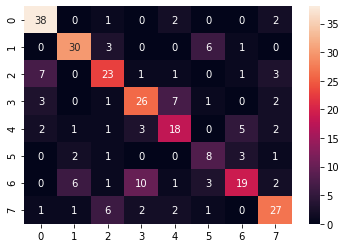

In [24]:
matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(matrix, annot= True)

# Building Decision Tree Classifier

In [25]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('DT', DecisionTreeClassifier(max_depth = 6))]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set
dt_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a classifier to the unscaled data
dt_unscaled = DecisionTreeClassifier(max_depth = 6).fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(dt_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(dt_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.3298611111111111
Accuracy without Scaling: 0.3368055555555556


## Predictions

In [27]:
dtree_predictions = dt_unscaled.predict(X_test) 
print(classification_report(y_test,dtree_predictions)) 

              precision    recall  f1-score   support

       angry       0.62      0.49      0.55        43
        calm       0.33      0.60      0.42        40
     disgust       0.22      0.19      0.21        36
     fearful       0.39      0.33      0.36        40
       happy       0.38      0.09      0.15        32
     neutral       0.17      0.13      0.15        15
         sad       0.26      0.24      0.25        42
   surprised       0.29      0.42      0.35        40

    accuracy                           0.34       288
   macro avg       0.33      0.31      0.30       288
weighted avg       0.35      0.34      0.32       288



## Confusion Matrix

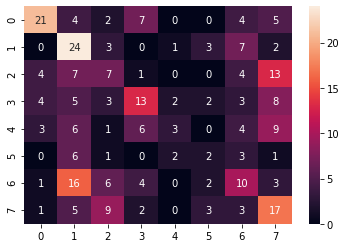

In [28]:
matrix = confusion_matrix(y_test, dtree_predictions)
sns.heatmap(matrix, annot= True)

# Building XGB Classifier

In [31]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('xgb', XGBClassifier())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set
xgb_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a classifier to the unscaled data
xgb_unscaled = XGBClassifier().fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(xgb_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(xgb_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.5381944444444444
Accuracy without Scaling: 0.5381944444444444


## Predictions

In [33]:
xgb_predictions = xgb_scaled.predict(X_test) 
print(classification_report(y_test,xgb_predictions)) 

              precision    recall  f1-score   support

       angry       0.69      0.81      0.74        43
        calm       0.60      0.75      0.67        40
     disgust       0.39      0.42      0.41        36
     fearful       0.50      0.55      0.52        40
       happy       0.47      0.44      0.45        32
     neutral       0.23      0.20      0.21        15
         sad       0.59      0.31      0.41        42
   surprised       0.57      0.57      0.57        40

    accuracy                           0.54       288
   macro avg       0.51      0.51      0.50       288
weighted avg       0.53      0.54      0.53       288



## Confusion Matrix

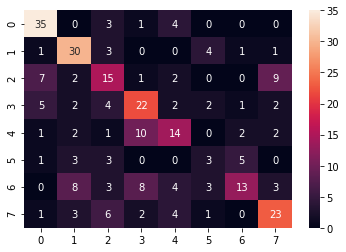

In [34]:
matrix = confusion_matrix(y_test, xgb_predictions)
sns.heatmap(matrix, annot= True)

# Building SVM Classifier

In [35]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('SVM', SVC())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: svc_scaled
svc_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a classifier to the unscaled data
svc_unscaled = SVC(kernel = 'linear').fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(svc_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(svc_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.5833333333333334
Accuracy without Scaling: 0.5104166666666666


## Predictions

In [36]:
svm_predictions = svc_scaled.predict(X_test) 
print(classification_report(y_test,svm_predictions)) 

              precision    recall  f1-score   support

       angry       0.79      0.70      0.74        43
        calm       0.62      0.78      0.69        40
     disgust       0.49      0.56      0.52        36
     fearful       0.55      0.65      0.60        40
       happy       0.55      0.38      0.44        32
     neutral       0.50      0.13      0.21        15
         sad       0.54      0.45      0.49        42
   surprised       0.55      0.70      0.62        40

    accuracy                           0.58       288
   macro avg       0.57      0.54      0.54       288
weighted avg       0.58      0.58      0.57       288



## Confusion Matrix

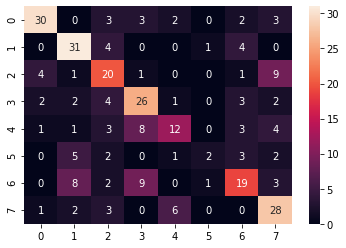

In [37]:
matrix = confusion_matrix(y_test, svm_predictions)
sns.heatmap(matrix, annot= True)

# THE END